In [61]:

pip install sentence-transformers


In [3]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

In [63]:
df = pd.read_csv("/content/NqndMEyZakuimmFI.xlsx")

In [64]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [65]:
len(df['department'].unique())

1164

In [66]:
len(df['function'].unique())
df['function'].count() - df['function'].isnull().sum()

np.int64(3966)

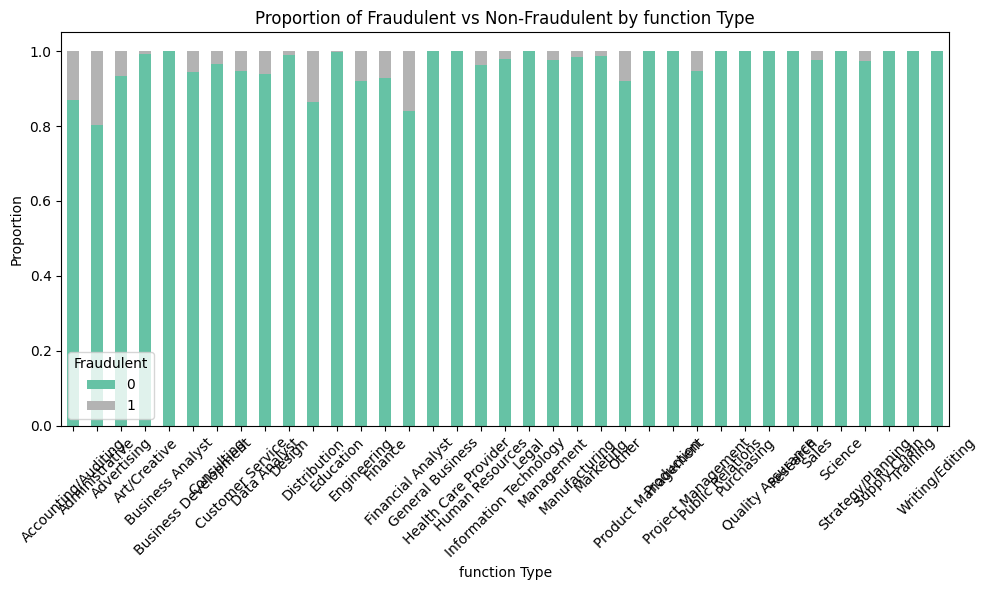

In [67]:
normalized_df = df.groupby('function')['fraudulent'].value_counts(normalize=True).unstack()

# Plot
normalized_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Proportion of Fraudulent vs Non-Fraudulent by function Type')
plt.ylabel('Proportion')
plt.xlabel('function Type')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
fraud_summary = df.groupby(['function', 'fraudulent']).size().unstack(fill_value=0)
fraud_summary[fraud_summary[1] == 0]

fraudulent,0,1
function,,
Business Analyst,69,0
General Business,49,0
Health Care Provider,263,0
Legal,34,0
Product Management,91,0
Production,84,0
Public Relations,60,0
Purchasing,11,0
Quality Assurance,87,0


In [69]:
df['employment_type'].unique()

array(['Full-time', nan, 'Contract', 'Temporary', 'Part-time', 'Other'],
      dtype=object)

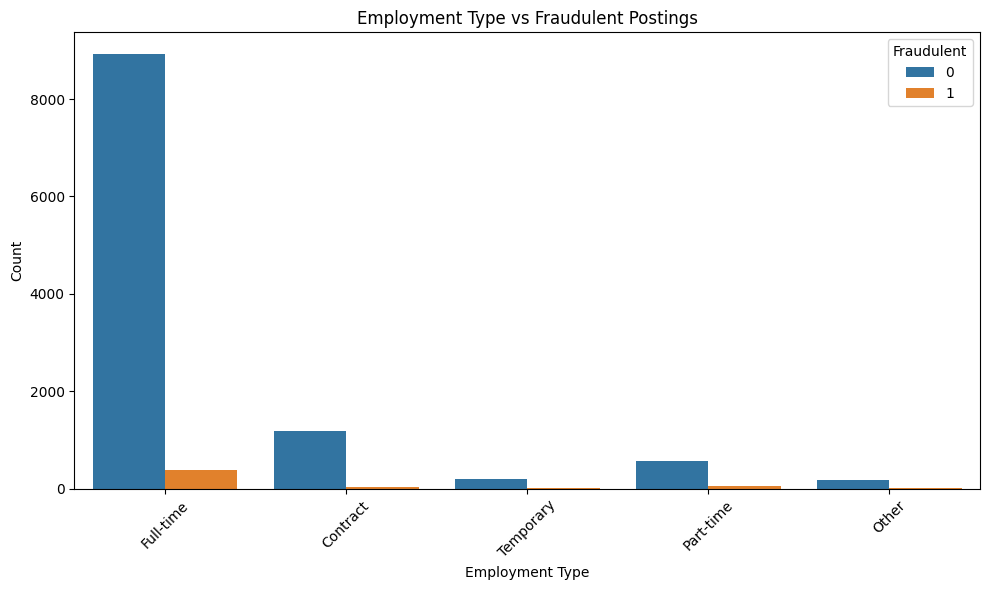

In [70]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='employment_type', hue='fraudulent')
plt.title('Employment Type vs Fraudulent Postings')
plt.xticks(rotation=45)
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

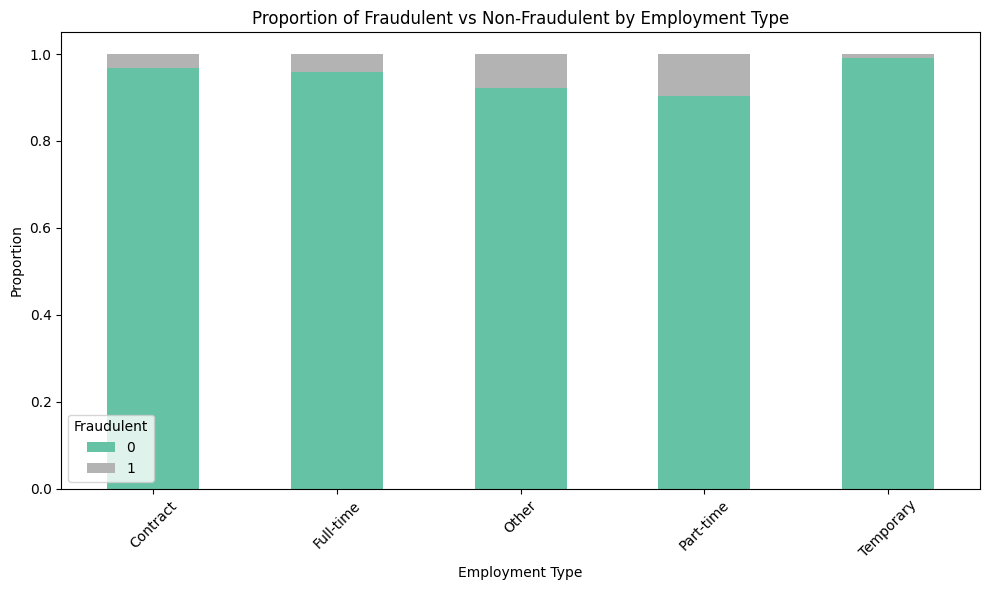

In [71]:
normalized_df = df.groupby('employment_type')['fraudulent'].value_counts(normalize=True).unstack()

# Plot
normalized_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Proportion of Fraudulent vs Non-Fraudulent by Employment Type')
plt.ylabel('Proportion')
plt.xlabel('Employment Type')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
df.isnull().sum()

,0
job_id,0
title,0
location,280
department,9275
salary_range,12021
company_profile,2672
description,1
requirements,2132
benefits,5803
telecommuting,0


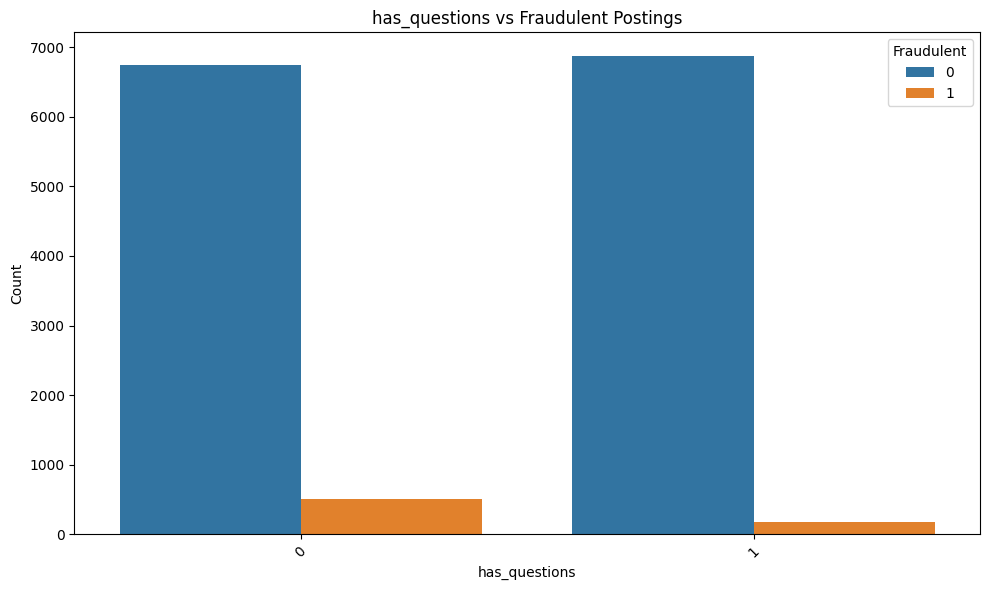

In [73]:

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='has_questions', hue='fraudulent')
plt.title('has_questions vs Fraudulent Postings')
plt.xticks(rotation=45)
plt.xlabel('has_questions')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

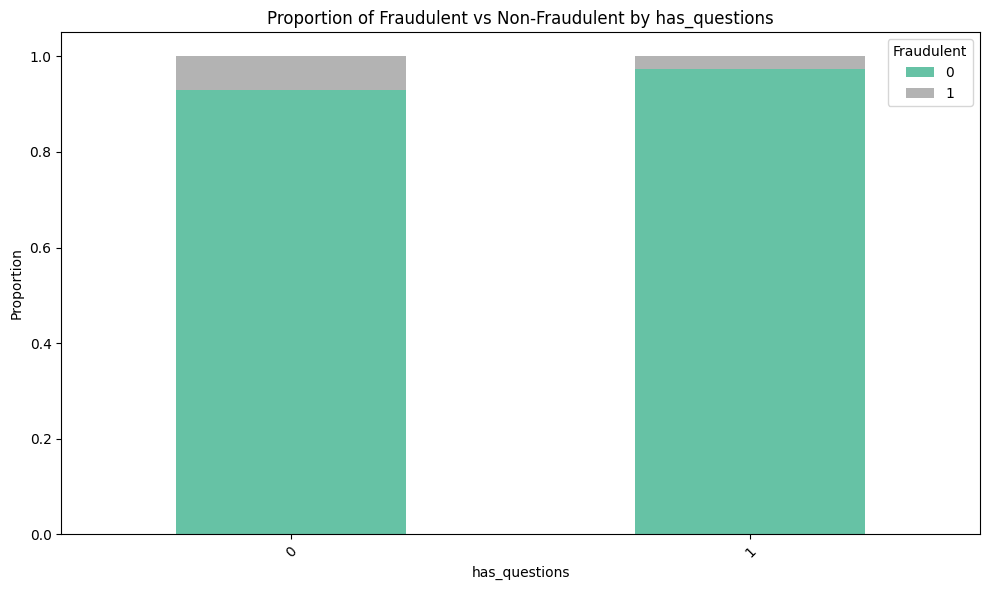

In [74]:
normalized_df = df.groupby('has_questions')['fraudulent'].value_counts(normalize=True).unstack()

# Plot
normalized_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Proportion of Fraudulent vs Non-Fraudulent by has_questions')
plt.ylabel('Proportion')
plt.xlabel('has_questions')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


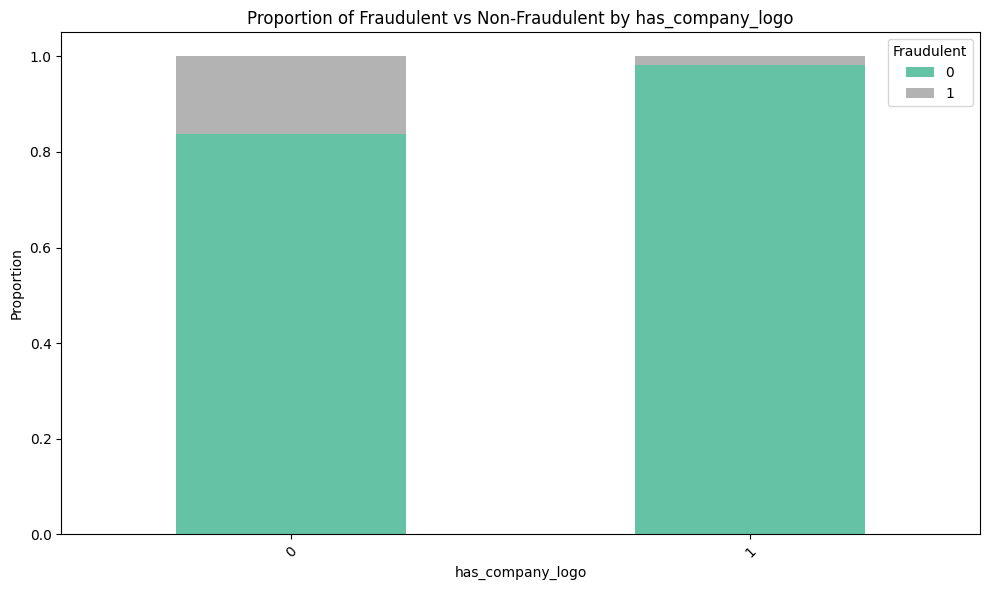

In [75]:
normalized_df = df.groupby('has_company_logo')['fraudulent'].value_counts(normalize=True).unstack()

# Plot
normalized_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Proportion of Fraudulent vs Non-Fraudulent by has_company_logo')
plt.ylabel('Proportion')
plt.xlabel('has_company_logo')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


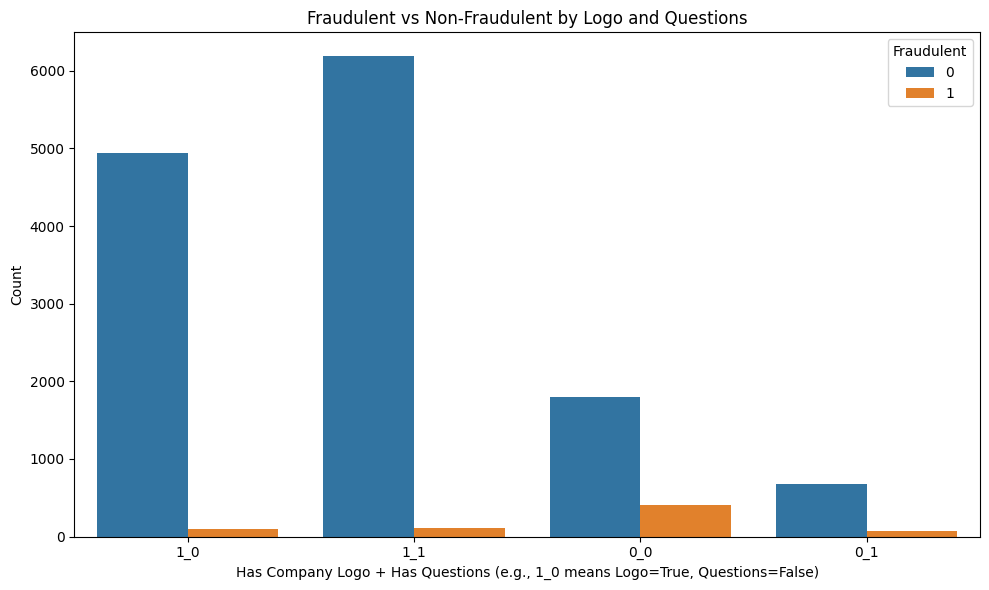

In [76]:
df['has_company_logo'] = df['has_company_logo'].astype(str)
df['has_questions'] = df['has_questions'].astype(str)
df['fraudulent'] = df['fraudulent'].astype(str)

# Create a combined feature
df['logo_questions'] = df['has_company_logo'] + "_" + df['has_questions']

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='logo_questions', hue='fraudulent')
plt.title('Fraudulent vs Non-Fraudulent by Logo and Questions')
plt.xlabel('Has Company Logo + Has Questions (e.g., 1_0 means Logo=True, Questions=False)')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

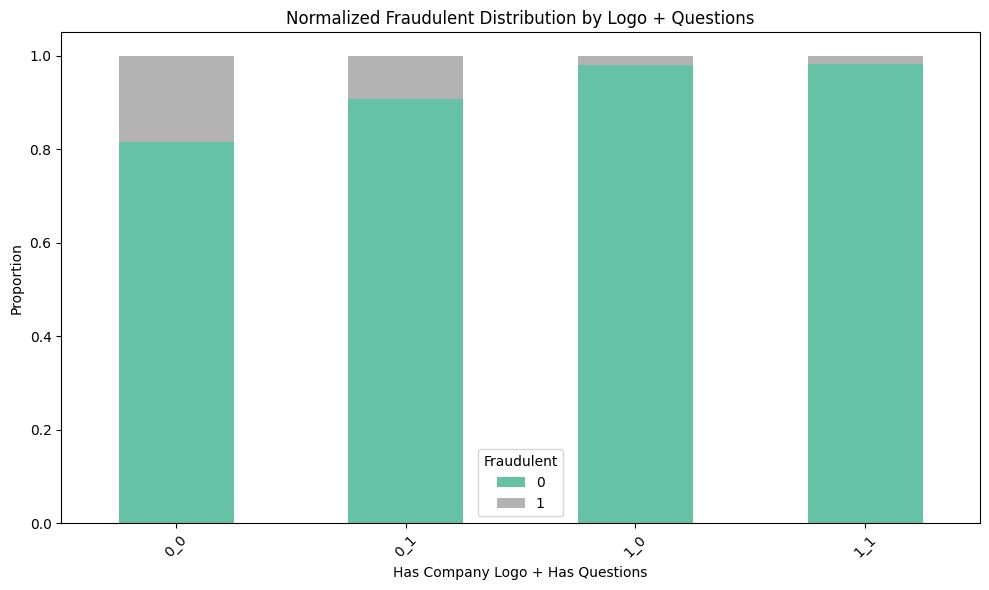

In [77]:
# Step 1: Group by 'logo_questions' and 'fraudulent' to get counts
grouped = df.groupby(['logo_questions', 'fraudulent']).size().unstack(fill_value=0)

# Step 2: Normalize by row (i.e., by each 'logo_questions' group)
normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Step 3: Plot
normalized.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')

plt.title('Normalized Fraudulent Distribution by Logo + Questions')
plt.xlabel('Has Company Logo + Has Questions')
plt.ylabel('Proportion')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
df['has_company_logo'] = df['has_company_logo'].astype(int)
df['has_questions'] = df['has_questions'].astype(int)

df['logo_questions_group'] = np.left_shift(df['has_company_logo'], 1) + df['has_questions'] + 1

In [79]:


model = SentenceTransformer('all-MiniLM-L6-v2')

In [82]:

text_data = (
 df['title'].fillna('') + ' ' +
 df['company_profile'].fillna('') + ' ' +
 df['description'].fillna('') + ' ' +
 df['requirements'].fillna('') + ' ' +
 df['benefits'].fillna('')
)

# Generate embeddings in batches
batch_size = 64
embeddings = []

for i in range(0, len(text_data), batch_size):
  batch = text_data[i:i+batch_size].tolist()
  batch_embeddings = model.encode(batch)
  embeddings.append(batch_embeddings)

# Combine all batches
embedding_df = pd.DataFrame(np.vstack(embeddings))



In [83]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.104674,-0.009502,0.033692,-0.061758,-0.025900,0.032283,-0.052686,0.012121,-0.031696,-0.078312,...,0.018982,0.058401,-0.018068,-0.071319,-0.043370,0.044209,-0.047659,-0.046638,0.030361,-0.002944
1,-0.096968,-0.061156,0.032740,-0.014845,-0.136236,0.039445,0.031455,0.033295,-0.030588,-0.077520,...,-0.065498,0.018353,0.114014,0.008116,0.040426,-0.008272,-0.123749,-0.042179,0.013090,-0.003740
2,-0.072214,-0.047441,-0.068538,0.059089,0.088164,-0.048801,0.022871,0.077242,-0.046167,0.037751,...,0.069768,0.048513,0.055176,-0.024959,-0.008842,0.151043,0.001052,-0.118857,0.059079,-0.004182
3,-0.068159,0.050683,0.024760,-0.030802,-0.054053,0.003545,-0.026478,0.024037,-0.013642,-0.053770,...,-0.021017,0.045145,-0.024822,-0.056910,0.165516,0.012954,-0.077619,-0.032130,-0.008404,0.069118
4,-0.017301,-0.011286,0.014259,0.024312,0.015674,-0.062632,0.031688,0.055835,-0.067045,-0.034193,...,0.028637,-0.052495,0.030603,0.050783,0.008792,0.057940,0.043163,-0.052096,0.046847,-0.004541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14299,-0.034051,-0.046200,-0.062293,0.016943,0.022703,-0.016330,0.085188,0.018236,-0.010778,-0.021528,...,-0.098725,-0.018428,0.024288,0.054465,0.029367,0.105808,0.029276,-0.050026,-0.018798,0.082486
14300,-0.100682,-0.024288,0.056025,-0.049412,0.006796,-0.030537,0.013264,-0.002699,-0.007252,0.011114,...,0.034679,-0.010425,-0.036363,-0.055638,0.010586,0.056898,0.080033,-0.019543,-0.021331,0.071885
14301,0.030802,-0.077585,-0.099601,0.013978,-0.098913,-0.012233,-0.022108,0.062515,-0.010742,-0.009241,...,0.012184,-0.013562,-0.039449,0.059533,0.001322,-0.007215,-0.011371,-0.096112,-0.044138,0.030082
14302,-0.099336,-0.054693,-0.007324,-0.022159,-0.135212,0.015121,0.063284,0.027441,-0.042907,-0.051087,...,-0.050294,0.037688,0.096770,-0.023258,0.078298,0.045944,-0.054601,-0.028673,0.001797,-0.032123


In [84]:

embedding_df.to_csv('embeddings.csv', index=False)

# Save as Pickle
embedding_df.to_pickle('embeddings.pkl')

# Save as NumPy .npy file
np.save('embeddings.npy', embedding_df.values)

print("Embeddings saved as 'embeddings.csv', 'embeddings.pkl', and 'embeddings.npy'.")


Embeddings saved as 'embeddings.csv', 'embeddings.pkl', and 'embeddings.npy'.


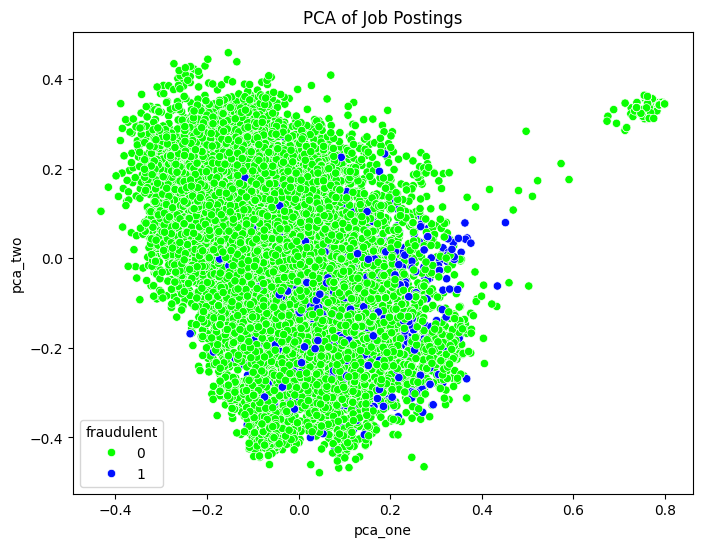

In [86]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_df)

# Add PCA results to the DataFrame
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_one', y='pca_two',
    hue='fraudulent',
    palette=sns.color_palette('hsv', 2),
    data=df,
    legend='full'
)
plt.title('PCA of Job Postings')
plt.show()



In [87]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'logo_questions', 'logo_questions_group', 'pca_one',
       'pca_two'],
      dtype='object')

In [89]:
df['telecommuting'].unique()
df['telecommuting'].isnull().sum()

np.int64(0)

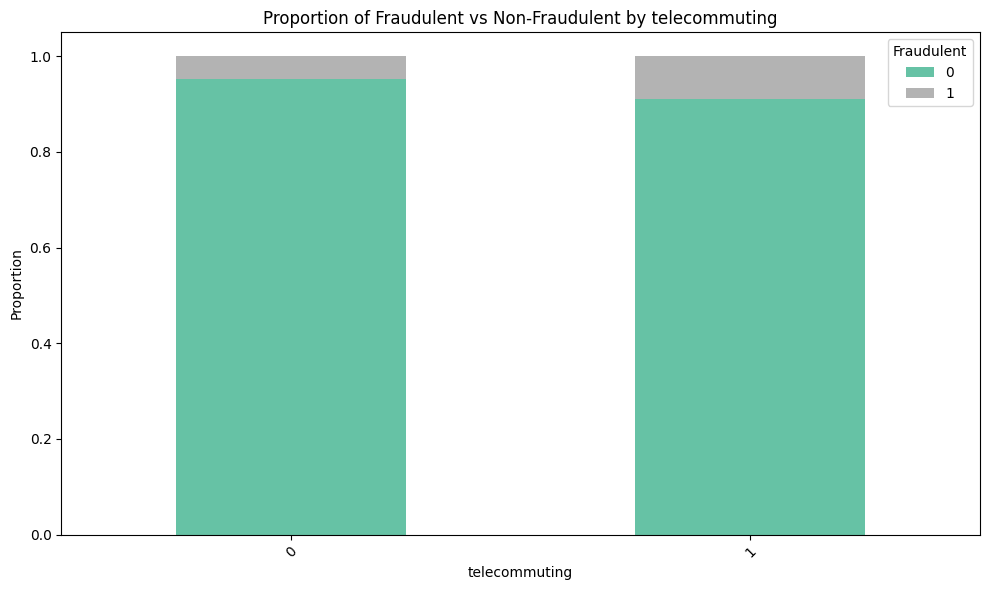

In [90]:
normalized_df = df.groupby('telecommuting')['fraudulent'].value_counts(normalize=True).unstack()

# Plot
normalized_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Proportion of Fraudulent vs Non-Fraudulent by telecommuting')
plt.ylabel('Proportion')
plt.xlabel('telecommuting')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

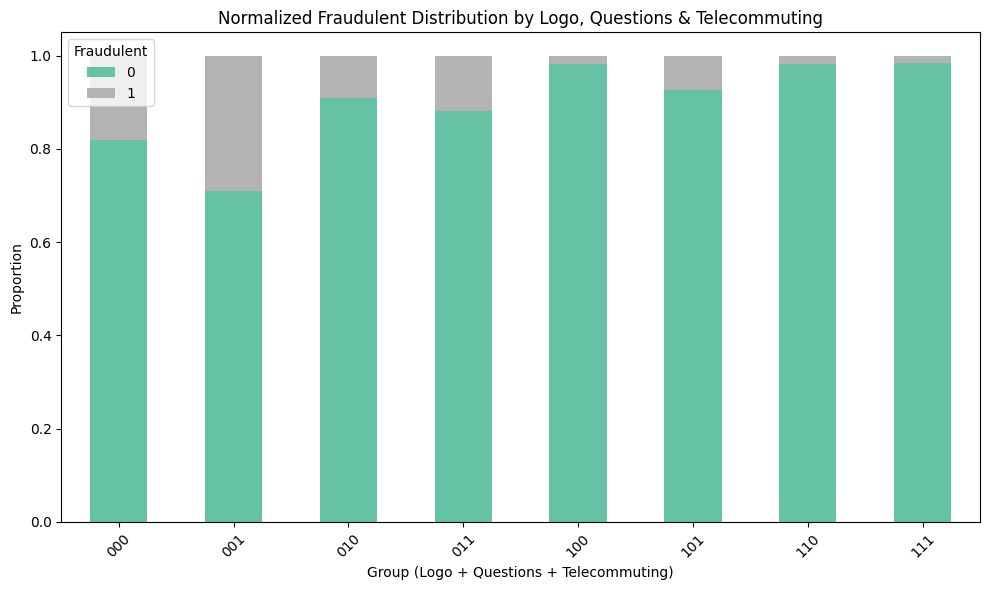

In [91]:
# Ensure binary columns are integers
df['has_company_logo'] = df['has_company_logo'].astype(int)
df['has_questions'] = df['has_questions'].astype(int)
df['telecommuting'] = df['telecommuting'].astype(int)
df['fraudulent'] = df['fraudulent'].astype(int)

# Step 1: Create a combined group key
df['logo_questions_tele'] = (
    df['has_company_logo'].astype(str) +
    df['has_questions'].astype(str) +
    df['telecommuting'].astype(str)
)

# Step 2: Group by the combined key and fraudulent
grouped = df.groupby(['logo_questions_tele', 'fraudulent']).size().unstack(fill_value=0)

# Step 3: Normalize by row
normalized = grouped.div(grouped.sum(axis=1), axis=0)

# Step 4: Plot
normalized.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')

plt.title('Normalized Fraudulent Distribution by Logo, Questions & Telecommuting')
plt.xlabel('Group (Logo + Questions + Telecommuting)')
plt.ylabel('Proportion')
plt.legend(title='Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


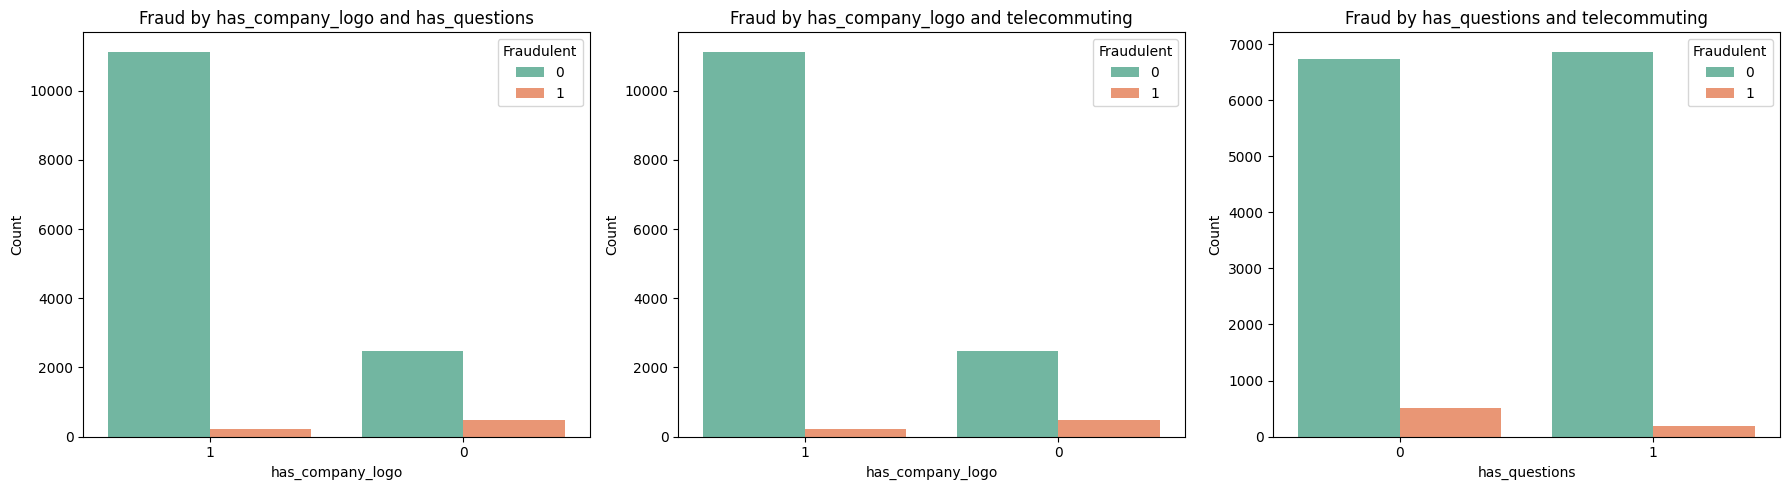

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure features are int or string for categorical plotting
for col in ['has_company_logo', 'has_questions', 'telecommuting', 'fraudulent']:
    df[col] = df[col].astype(str)

pairs = [
    ('has_company_logo', 'has_questions'),
    ('has_company_logo', 'telecommuting'),
    ('has_questions', 'telecommuting')
]

plt.figure(figsize=(18, 5))

for i, (feat1, feat2) in enumerate(pairs, 1):
    plt.subplot(1, 3, i)
    sns.countplot(
        data=df,
        x=feat1,
        hue='fraudulent',
        palette='Set2',
        dodge=True
    )
    plt.title(f'Fraud by {feat1} and {feat2}')
    plt.xlabel(feat1)
    plt.ylabel('Count')
    plt.legend(title='Fraudulent')

plt.tight_layout()
plt.show()


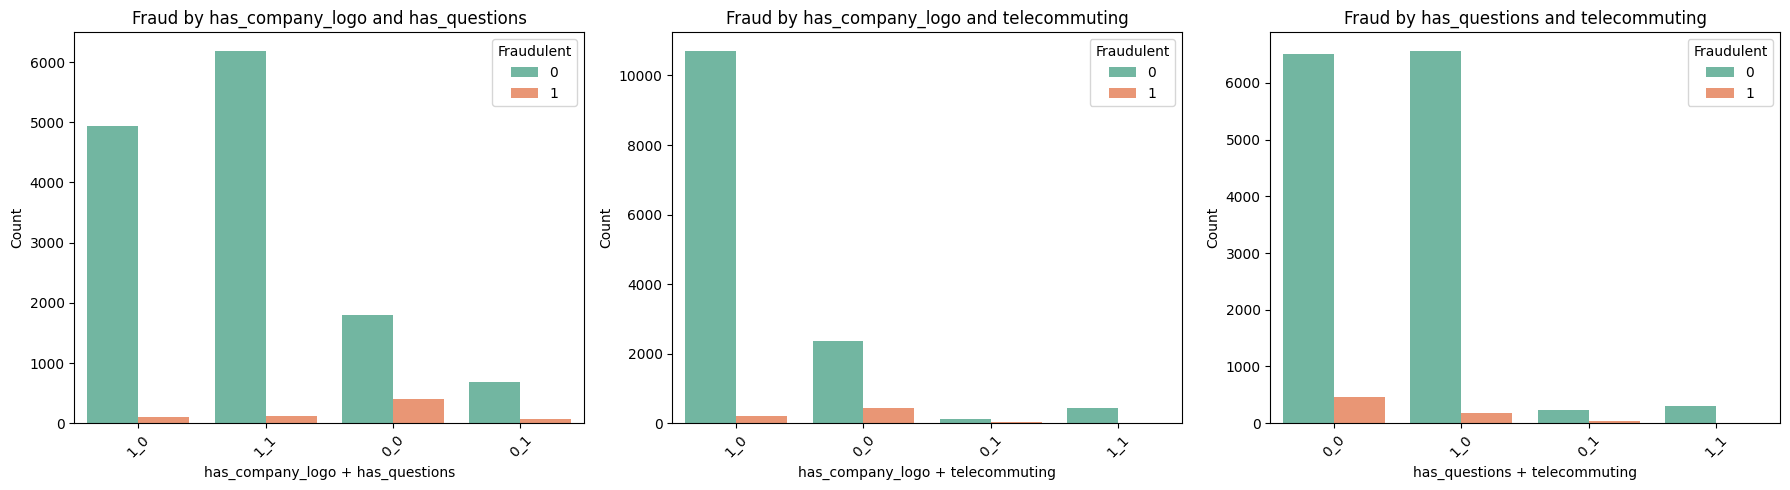

In [93]:
plt.figure(figsize=(18, 5))

for i, (feat1, feat2) in enumerate(pairs, 1):
    # Combine two features as string label, e.g. '1_0'
    df['combo'] = df[feat1] + '_' + df[feat2]

    plt.subplot(1, 3, i)
    sns.countplot(data=df, x='combo', hue='fraudulent', palette='Set2')
    plt.title(f'Fraud by {feat1} and {feat2}')
    plt.xlabel(f'{feat1} + {feat2}')
    plt.ylabel('Count')
    plt.legend(title='Fraudulent')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


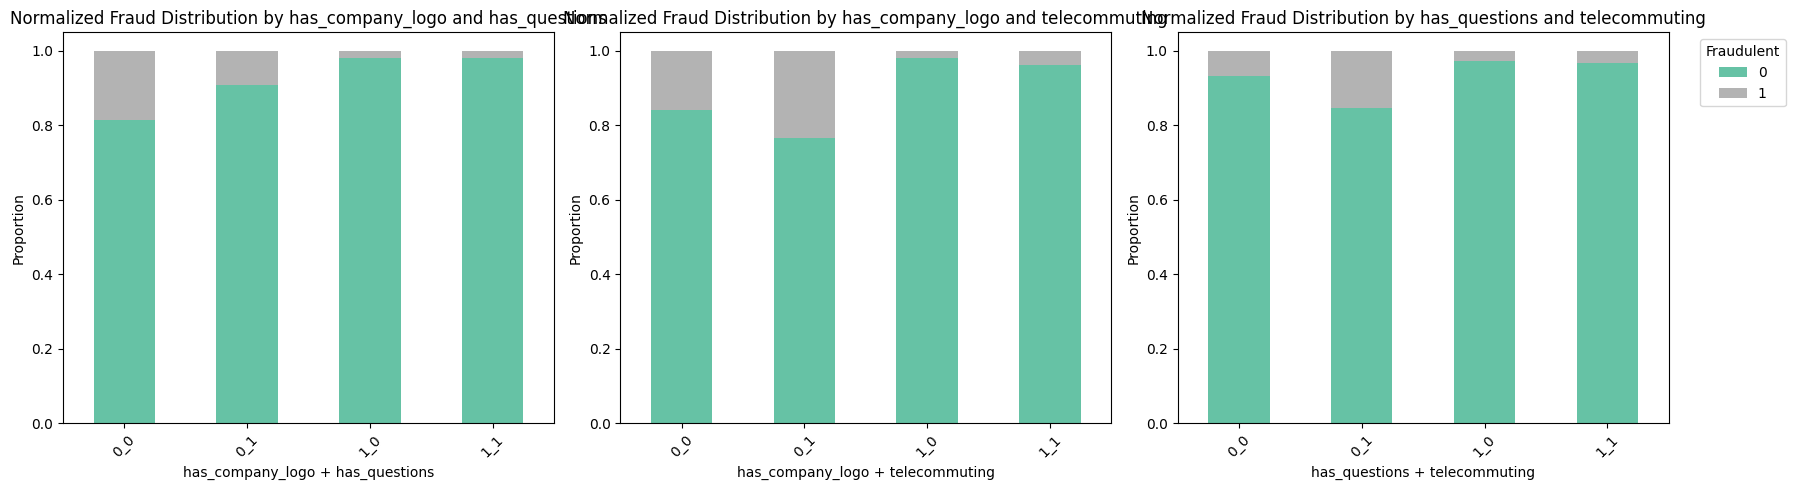

In [94]:
import matplotlib.pyplot as plt

pairs = [
    ('has_company_logo', 'has_questions'),
    ('has_company_logo', 'telecommuting'),
    ('has_questions', 'telecommuting')
]

plt.figure(figsize=(18, 5))

for i, (feat1, feat2) in enumerate(pairs, 1):
    # Create combined feature
    df['combo'] = df[feat1] + '_' + df[feat2]

    # Group and normalize fraud counts per combo
    grouped = df.groupby(['combo', 'fraudulent']).size().unstack(fill_value=0)
    normalized = grouped.div(grouped.sum(axis=1), axis=0)

    # Plot stacked bar
    plt.subplot(1, 3, i)
    normalized.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2', legend=False)

    plt.title(f'Normalized Fraud Distribution by {feat1} and {feat2}')
    plt.xlabel(f'{feat1} + {feat2}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)

plt.legend(title='Fraudulent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [104]:
print(len(df['salary_range']) - df['salary_range'].isnull().sum())

len(df['salary_range'].unique())

2283


772

In [119]:
print(df['salary_range'].dtype)
print(df['salary_range'].dropna().head(10))


float64
Series([], Name: salary_range, dtype: float64)


<ipython-input-118-657670702>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


ValueError: cannot convert float NaN to integer

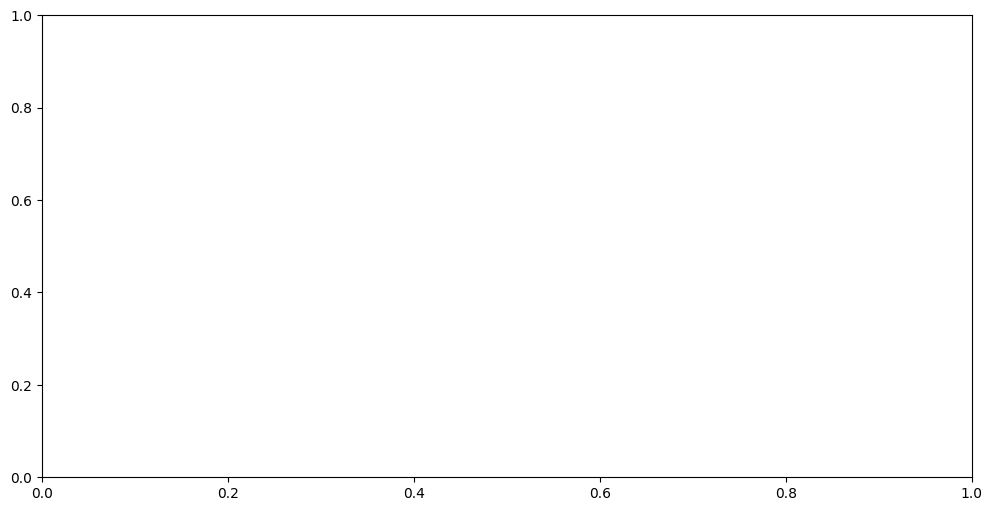

In [118]:
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_salary,
    x='salary_parsed',
    hue='fraudulent',
    binwidth=100,
    multiple='stack',
    palette='Set1',
    edgecolor='black'
)

plt.title('Salary Distribution by Fraudulent Label')
plt.xlabel('Salary (parsed average)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [115]:
print(df['salary_range'].dropna().head(10))


Series([], Name: salary_range, dtype: float64)


In [5]:
ds = pd.read_csv('/content/NqndMEyZakuimmFI.xlsx')

In [121]:
print(ds['salary_range'].dtype)
print(ds['salary_range'].dropna().head(10))

object
5          0-92000
8        7500-8000
14     35000-45000
17     65000-70000
37     60000-80000
41     30000-50000
42     16000-18000
43     28000-30000
47             0-0
49    80000-100000
Name: salary_range, dtype: object


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


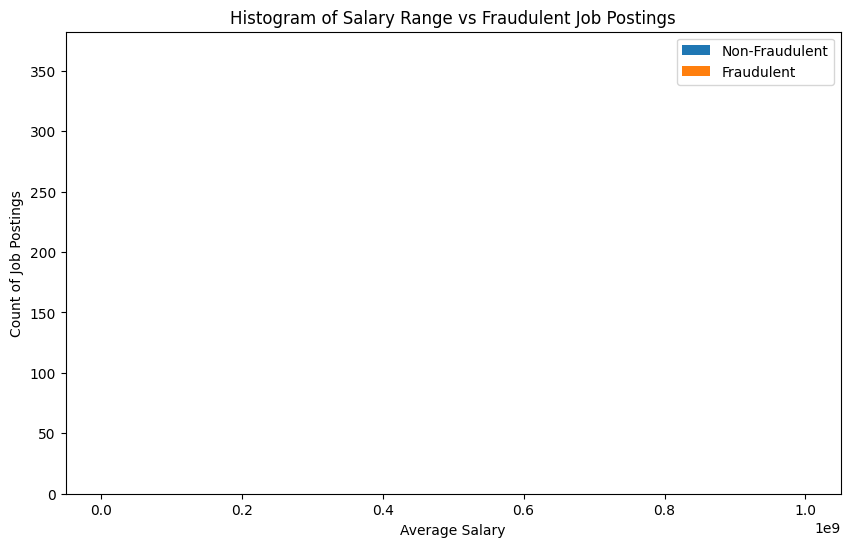

In [8]:
def parse_salary_range(salary_range):
    try:
        min_salary, max_salary = map(int, salary_range.split('-'))
        return (min_salary + max_salary) / 2
    except:
        return np.nan

# Apply the function to the salary_range column
ds['average_salary'] = ds['salary_range'].apply(parse_salary_range)

# Drop rows with NaN values in average_salary
ds = ds.dropna(subset=['average_salary'])

# Define bin size
bin_size = 10000

# Create bins for average_salary
bins = np.arange(0, ds['average_salary'].max() + bin_size, bin_size)
ds['salary_bin'] = pd.cut(ds['average_salary'], bins)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist([ds[ds['fraudulent'] == 0]['average_salary'], ds[ds['fraudulent'] == 1]['average_salary']], bins=bins, stacked=True, label=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Average Salary')
plt.ylabel('Count of Job Postings')
plt.title('Histogram of Salary Range vs Fraudulent Job Postings')
plt.legend()
plt.show()



In [6]:
plt.figure(figsize=(10, 6))
plt.hist([ds[ds['fraudulent'] == 0]['average_salary'], ds[ds['fraudulent'] == 1]['average_salary']], bins=bins, stacked=True, label=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Average Salary')
plt.ylabel('Count of Job Postings')
plt.title('Histogram of Salary Range vs Fraudulent Job Postings')
plt.legend()
plt.show()

KeyError: 'average_salary'

<Figure size 1000x600 with 0 Axes>

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Load your dataset
df = pd.read_csv("/content/NqndMEyZakuimmFI.xlsx")  # Replace with your actual file path

# Select categorical features
categorical_features = [
    'telecommuting', 'has_company_logo', 'has_questions',
    'employment_type', 'required_experience', 'required_education',
    'industry', 'function'
]

# One-Hot Encode binary/nominal features
onehot_features = ['telecommuting', 'has_company_logo', 'has_questions']

onehot_encoder = OneHotEncoder(sparse_output=False)

onehot_encoded = onehot_encoder.fit_transform(df[onehot_features])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(onehot_features))

# Label Encode ordinal/multi-class features
label_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
label_df = df[label_features].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

# Combine all encoded features
encoded_df = pd.concat([onehot_df, label_df], axis=1)

# Save the encoded features
encoded_df.to_csv("encoded_features.csv", index=False)
encoded_df.to_pickle("encoded_features.pkl")
np.save("encoded_features.npy", encoded_df.values)

print("Categorical features encoded and saved successfully.")


Categorical features encoded and saved successfully.


In [11]:
encoded_df

,telecommuting_0,telecommuting_1,has_company_logo_0,has_company_logo_1,has_questions_0,has_questions_1,employment_type,required_experience,required_education,industry,function
0,1.0,0.0,0.0,1.0,1.0,0.0,1,2,9,38,7
1,1.0,0.0,0.0,1.0,1.0,0.0,1,2,4,118,7
2,1.0,0.0,0.0,1.0,0.0,1.0,1,5,13,57,37
3,1.0,0.0,0.0,1.0,1.0,0.0,1,7,13,10,31
4,1.0,0.0,0.0,1.0,1.0,0.0,1,5,1,60,22
...,...,...,...,...,...,...,...,...,...,...,...
14299,1.0,0.0,0.0,1.0,0.0,1.0,0,0,1,57,27
14300,1.0,0.0,0.0,1.0,0.0,1.0,5,7,13,129,37
14301,1.0,0.0,0.0,1.0,1.0,0.0,1,2,4,106,37
14302,1.0,0.0,0.0,1.0,1.0,0.0,1,2,4,65,1


In [12]:
df = pd.read_csv('/content/embeddings.csv')


In [13]:
df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '374', '375', '376', '377', '378', '379', '380', '381', '382', '383'],
      dtype='object', length=384)